# Training the Model for Spotify Similar Song Finder

### Imports

In [118]:
from __future__ import print_function

import os
import json
import time
import sys
from dotenv import load_dotenv

import pandas as pd
import numpy as np  
import seaborn as sn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors



import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

load_dotenv()
client_id = os.getenv("SPOTIPY_CLIENT_ID")
client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

### Load data

In [119]:
df=pd.read_csv('../data/spotify_data.csv')

In [120]:
df

,artist_name,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri
0,Rend Collective,Rescuer (Good News),0.491,0.7460,7,-4.872,1,0.0565,0.39600,0.000000,0.3680,0.6270,152.022,spotify:track:32f24TdkpHx8L0EZX2HbP4
1,Yuna,Lullabies - Adventure Club Remix,0.403,0.6980,9,-5.058,0,0.0357,0.00171,0.001260,0.2560,0.0833,159.869,spotify:track:3RJuptH9QoeJWzHd4ZCI0u
2,Tech N9ne,Shut the F**k Up (Skit),0.000,0.9500,9,-8.761,1,0.0000,0.51000,0.071200,0.8720,0.0000,0.000,spotify:track:4oiXR2h98f196Ov2wCjCJS
3,Bayside,Landing Feet First,0.436,0.3320,9,-7.649,1,0.0406,0.00434,0.000000,0.1090,0.3290,174.901,spotify:track:3y0ycPzjAE6R66u3aw8MBk
4,Iamsu!,Back On My BS (feat. Skipper & Problem),0.755,0.8090,7,-5.954,0,0.1660,0.17400,0.000000,0.1810,0.5490,98.035,spotify:track:3AtNkheraHcfe0ubFQ9Xp1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,Huey Lewis & The News,If This Is It,0.512,0.4930,7,-12.964,1,0.0276,0.15500,0.000005,0.1280,0.8360,146.668,spotify:track:6xBedrkburGrmhQGvlBfoH
8469,Murry Jonathan Gold,Doctor Who 'I Am The Doctor' For Orchestra,0.589,0.7920,2,-5.145,0,0.0337,0.06240,0.881000,0.0602,0.3890,90.981,spotify:track:2aDZw6PUiIBcIYZ9d47jwa
8470,Musica de Piano Escuela,Kiss the Rain,0.573,0.0707,8,-22.578,1,0.0469,0.98000,0.939000,0.1110,0.2030,131.016,spotify:track:7JpMDy3skWcOYdGDvE9ng9
8471,Piano Tribute Players,She Will Be Loved,0.485,0.2990,0,-18.445,0,0.0658,0.99200,0.924000,0.1120,0.1260,204.036,spotify:track:0aabUVAPbLV6sLtnM1lb8B


## EDA

In [121]:
df.isna().sum()

artist_name         4
track_name          4
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
uri                 0
dtype: int64

In [122]:
df.isnull().sum()   

artist_name         4
track_name          4
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
uri                 0
dtype: int64

In [123]:
df.dropna(inplace=True)
df.shape

(8469, 14)

In [124]:
df.dtypes

artist_name          object
track_name           object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
uri                  object
dtype: object

In [125]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,8469.000000,8469.000000,8469.000000,8469.000000,8469.000000,8469.000000,8469.000000,8469.000000,8469.000000,8469.000000,8469.000000
mean,0.590349,0.639286,5.230724,-7.716747,0.655213,0.093302,0.260505,0.101095,0.193916,0.487840,121.301987
std,0.163375,0.227660,3.613161,4.283933,0.475327,0.101800,0.300482,0.250645,0.163048,0.246573,29.099605
min,0.000000,0.001270,0.000000,-39.572000,0.000000,0.000000,0.000002,0.000000,0.017000,0.000000,0.000000
25%,0.483000,0.492000,2.000000,-9.247000,0.000000,0.035200,0.018700,0.000000,0.095500,0.294000,98.007000
50%,0.599000,0.675000,5.000000,-6.631000,1.000000,0.048900,0.121000,0.000014,0.125000,0.478000,120.112000
75%,0.707000,0.822000,8.000000,-4.961000,1.000000,0.098800,0.438000,0.007110,0.246000,0.683000,139.995000
max,0.978000,0.999000,11.000000,0.422000,1.000000,0.944000,0.996000,0.986000,0.991000,0.990000,220.169000


array([[<Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'key'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'tempo'}>, <Axes: >]], dtype=object)

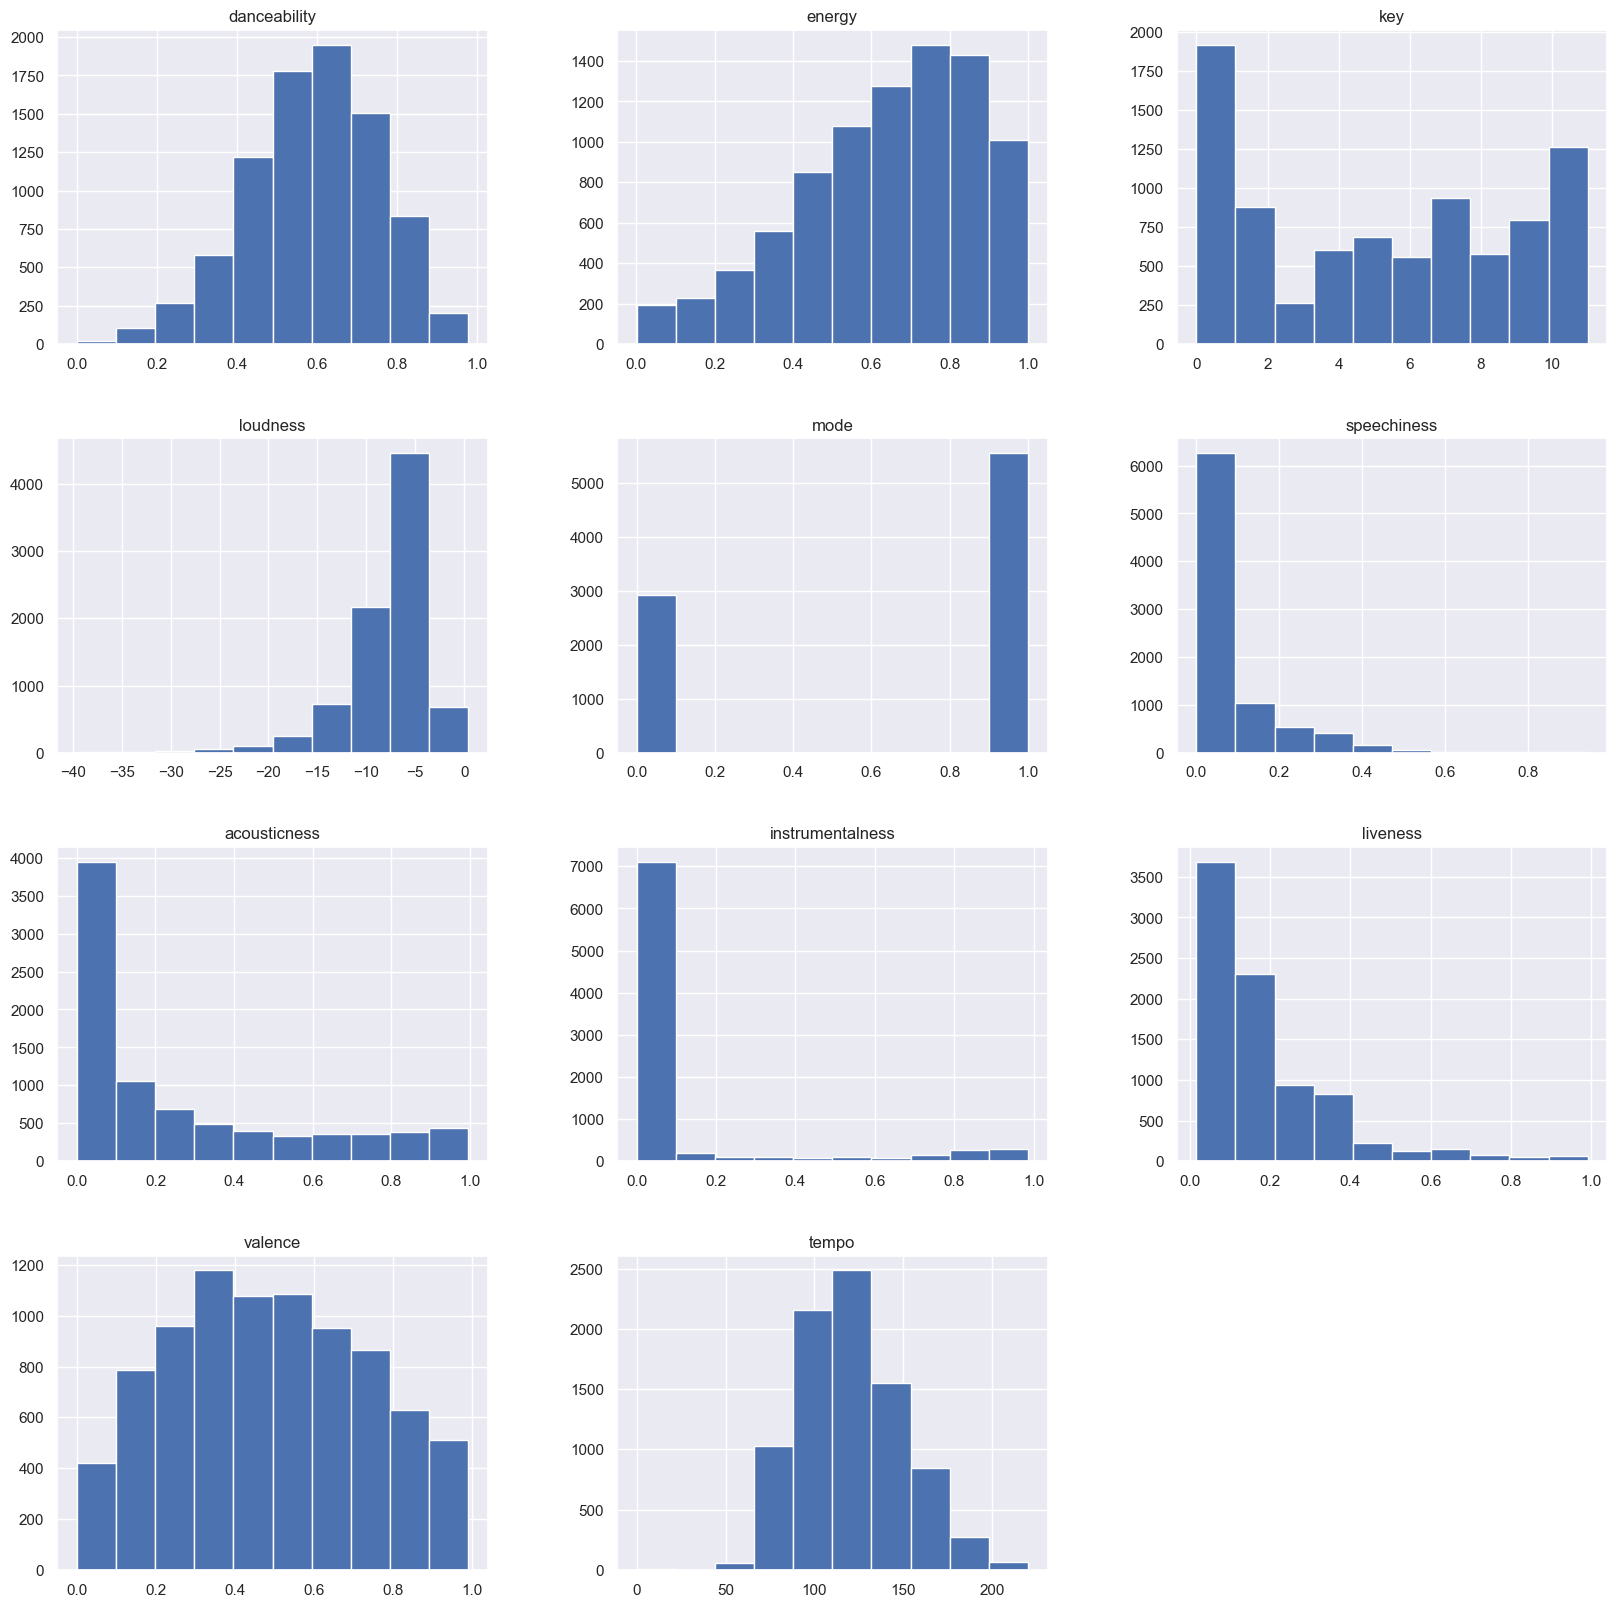

In [126]:
df.hist(figsize=(20,20))

For starters, I want to use all columns. Maybe later on PCA will be a good thing to do.

In [127]:
df_num = df.select_dtypes(include = ['float64', 'int64'])

<Axes: >

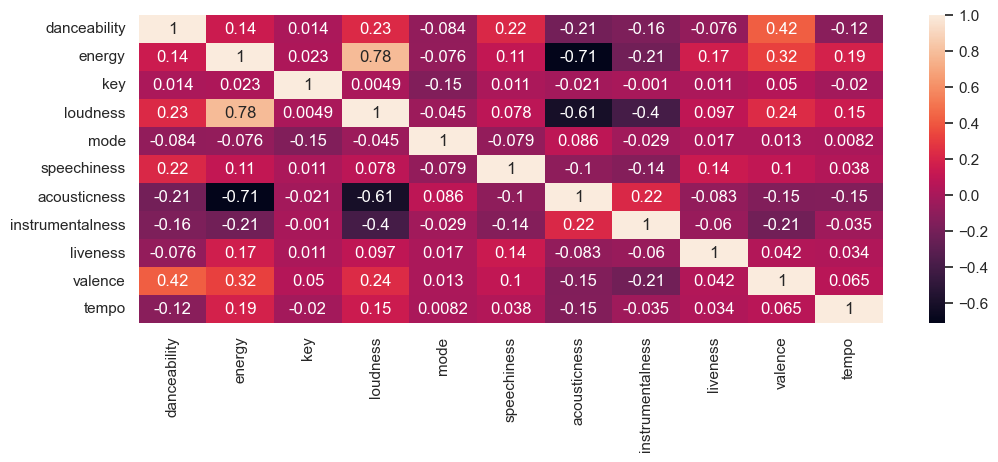

In [128]:
corr_matrix = df_num.corr()
sn.set (rc = {'figure.figsize':(12, 4)})
sn.heatmap(corr_matrix, annot=True)

### Encoding & Scaling

In [129]:
numeric_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
categorical_cols = ['key', 'mode']

# Create the preprocessing pipeline
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply the preprocessing pipeline to your DataFrame
df_processed = preprocessing_pipeline.fit_transform(df_num)

num_cols_transformed = numeric_cols
cat_cols_transformed = preprocessing_pipeline.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine the transformed column names
all_cols_transformed = num_cols_transformed + cat_cols_transformed.tolist()

# Convert the processed NumPy array back to a DataFrame
df_processed = pd.DataFrame(df_processed, columns=all_cols_transformed)


In [130]:
df_processed

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_0,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
0,0.450953,-0.608141,0.468769,-0.403364,1.067749,0.664089,-0.361537,1.055747,0.564411,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.861315,-1.146810,0.257916,-0.398337,0.380793,0.620669,-0.565871,1.325423,-1.640745,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.830366,-3.613669,1.364895,-0.119280,4.159051,-0.243775,-0.916578,-4.168756,-1.978596,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.852562,-0.944809,-1.349840,-0.403364,-0.520836,0.015815,-0.517734,1.842024,-0.644227,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.287903,1.007865,0.745514,-0.403364,-0.079222,0.411503,0.714162,-0.799611,0.248056,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,-0.351138,-0.479595,-0.642603,-0.403346,-0.404299,-1.224940,-0.645443,0.871748,1.412079,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8465,-0.659328,-0.008260,0.670837,3.111773,-0.820153,0.600359,-0.585518,-1.042034,-0.400877,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8466,2.394611,-0.106200,-2.497672,3.343189,-0.508569,-3.469272,-0.455845,0.333839,-1.155262,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8467,2.434549,-0.644869,-1.494801,3.283340,-0.502436,-2.504448,-0.270176,2.843300,-1.467561,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [131]:
# df_processed.hist(figsize=(20,20))

In [395]:

def transform_query(track_uri):
    audio_features = sp.audio_features(track_uri)[0]
    track_data = []
    track_dict = {
        'acousticness': audio_features['acousticness'],
        'danceability': audio_features['danceability'],
        'energy': audio_features['energy'],
        'instrumentalness': audio_features['instrumentalness'],
        'liveness': audio_features['liveness'],
        'loudness': audio_features['loudness'],
        'speechiness': audio_features['speechiness'],
        'tempo': audio_features['tempo'],
        'valence': audio_features['valence'],
        'key': audio_features['key'],
        'mode': audio_features['mode']
    }
    
    track_data.append(track_dict)
    query_data = pd.DataFrame(track_data)
    return query_data

In [396]:
knn_model = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='euclidean')
knn_model.fit(df_processed) # I'm using all the data for KNN

# Function to find similar songs to the input URI
def find_similar_songs(track_uri):

    query_data = transform_query(track_uri)
    
    # Scale the query data using the same scaler
    query_data_scaled = preprocessing_pipeline.transform(query_data)
    query_data_scaled_df = pd.DataFrame(query_data_scaled, columns=all_cols_transformed)

    # Find the most similar songs using the KNN model
    distances, indices = knn_model.kneighbors(query_data_scaled_df, n_neighbors=10)

    # Retrieve the Artist Name, Song Name, and Track URI of the most similar songs
    similar_songs = []
    for index in indices[0]:
        artist_name = df.iloc[index]['artist_name']
        song_name = df.iloc[index]['track_name']
        similar_uri = df.iloc[index]['uri']
        similar_songs.append((artist_name, song_name, similar_uri))

    return similar_songs

In [398]:

# Replace 'YOUR_TRACK_URI' with the track URI you want to find similar songs to
similar_songs = find_similar_songs('https://open.spotify.com/track/2Fxmhks0bxGSBdJ92vM42m?si=d8d6ffa9f4874c07')

# Print the results
for song in similar_songs:
    print(f"Artist: {song[0]}, Song: {song[1]}, Track URI: {song[2]}")


Artist: Yusuf / Cat Stevens, Song: Father And Son, Track URI: spotify:track:2tbdjsdJ9xtyunKnZBkGxF
Artist: Train, Song: Blind, Track URI: spotify:track:4EADnBeeLZoFyOJoGeoOw5
Artist: Bob Dylan, Song: Jokerman, Track URI: spotify:track:6cuHkcRUqtQhtJ4sWCkd1q
Artist: Temple Of The Dog, Song: Times Of Trouble, Track URI: spotify:track:4m1BHxinyAOrymQFKqTsr6
Artist: Bronski Beat, Song: Smalltown Boy, Track URI: spotify:track:0FrCX7P2C2hcRTcuhjEvK4
Artist: Aer, Song: Feel I Bring, Track URI: spotify:track:2p7QqN1aMNg6aVMTR78a2x
Artist: Ty Dolla $ign, Song: Know Ya (feat. Trey Songz), Track URI: spotify:track:2KB0DJBN3GPoXe9ZJPKE3u
Artist: Bob Dylan, Song: Mr. Tambourine Man - Live at Boston Music Hall, Boston, MA - November 21, 1975 - Afternoon, Track URI: spotify:track:0703Xd7Z3EHAddRthFYi6v
Artist: Drake, Song: Diamonds Dancing, Track URI: spotify:track:2AGottAzfC8bHzF7kEJ3Wa
Artist: Incubus, Song: Echo, Track URI: spotify:track:1sqkxy2WNAgpRtQfDP64MN
